In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

*** Naive analysis ***

To make this Naive analysis:

1) To have a global look at the data, we plot the distributions in box-plots to have an idea of data repartion and differences in medians between the two classes. Also, the mean and std within subjects and controls are computed and displayed in bar plots.

2) A statistical test is performed to test the null hypothesis H0 that the mean Re78 is equal for the two classes.


In [149]:
''' Load the data and extract the groups'''

observed_earnings = pd.read_csv('lalonde.csv', index_col=0)

# split the two groups
subjects = observed_earnings.loc[observed_earnings['treat']==1]
controls = observed_earnings.loc[observed_earnings['treat']==0]

# size of the groups
print('The observational data is build with {} subjects and {} controls'.format(len(subjects.index), len(controls.index)))

The observational data is build with 185 subjects and 429 controls


In [3]:
observed_earnings.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


,subjects-re78,controls-re78
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


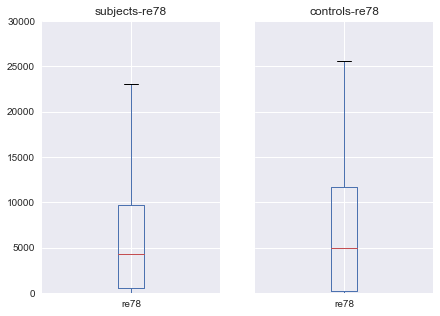

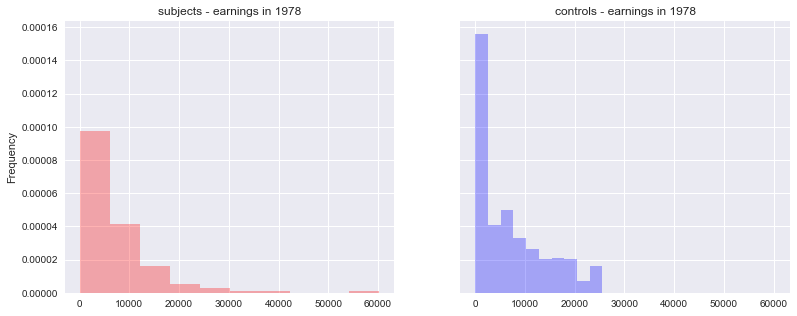

In [4]:
''' Simple vizualization of 1978 earnings distribution within classes'''

dist_re_78 = pd.DataFrame(index = ['count','mean','std','min','25%','50%','75%','max'])
dist_re_78['subjects-re78']= subjects['re78'].describe()
dist_re_78['controls-re78']= controls['re78'].describe()

fig, axes = plt.subplots(1, 2, figsize=(13,5), sharex=True,sharey=True);
subjects['re78'].plot.box(ax=axes[0],figsize=(7,5),ylim=[0,30000],title='subjects-re78')
controls['re78'].plot.box(ax=axes[1],figsize=(7,5),ylim=[0,30000],title='controls-re78')

fig, axes = plt.subplots(1, 2, figsize=(13,5), sharex=True,sharey=True);
subjects['re78'].plot.hist(ax=axes[0],facecolor='red',alpha=0.3, bins=10,normed=1, title='subjects - earnings in 1978')
controls['re78'].plot.hist(ax=axes[1],facecolor='blue',alpha=0.3, bins=10,normed=1,title='controls - earnings in 1978')

dist_re_78

The histograms seem to indicate that samples from subject class are more concentrated bellow 10000 whereas samples from control class are relatively more represented between 1000 and 2000 re78. However, subjects have high outliers (until 60 000) compared to controls. Moreover, samples from control group are more dense at zero (unemployed) compared to subjects. 
Note that those histograms were normalized to have a comparison indpendent of class sizes. 

The boxplot plots show the quantiles distribution, where 50% and 75% quantiles are bigger for controls but 25% quanile and maximum value are higher for subjects.
Computing the averages and standard deviations indicate that controls have a slight bigger average re78 compared to subjects. Moreover, the standard deviations are really high and relative to this, the difference in means may not be significative.

Those results suggest that there is no reliable difference between groups and thus that the Training Programm had no influence on the earnings.

In [5]:
'''To conclude this naive research, a statistical test is computed to compare the groups'''

from sklearn.feature_selection import chi2, f_classif
ns = len(observed_earnings.index)

X, y = observed_earnings.re78.values, observed_earnings.treat.values
F, p_val = f_classif(X.reshape([ns,1]),y.reshape(ns))

print('The Fisher ANOVA tests returns a p-value of {} for re78'.format(float(p_val)))

The Fisher ANOVA tests returns a p-value of 0.3342496685908978 for re78


The p_value is higher than the critical level of 0.05 meaning that one cannot reject the null hypothesis and thus the re78 averages may be equal between classes.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.



*** Feature exploration ***

1) To compare the features, histograms are used to summarize distributions of quantitative values like age, and years of education.

2) The cathegorical values are represented in terms of proportions of each subclass within the controls and subjects. One intuitive vizualization is done by plotting piecharts.

3) Earnings will be compared in terms of statistic measures as done with re78 but only the average and the standard deviations, to reduce the number of figures.

*** Bulk continuous variables ***

In [6]:
def plot_histograms(subjects,controls):

    plt.figure(1)
    fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True,sharey=True);

    subjects['age'].plot.hist(ax=axes[0],facecolor='red',normed=1,alpha=0.3, bins=10, title='subjects - age')
    controls['age'].plot.hist(ax=axes[1],facecolor='blue',normed=1,alpha=0.3, bins=10,title='controls - age')

    plt.figure(2)
    fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True,sharey=True);

    subjects['educ'].plot.hist(ax=axes[0],facecolor='red',normed=1,alpha=0.3, bins=10, title='subjects - educ')
    controls['educ'].plot.hist(ax=axes[1],facecolor='blue',normed=1,alpha=0.3, bins=10,title='controls - educ')

In [7]:
def plot_boxs(subjects,controls):

    plt.figure(1)
    fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True,sharey=True);

    subjects['age'].plot.box(ax=axes[0], title='subjects - age')
    controls['age'].plot.box(ax=axes[1], title='controls - age')

    plt.figure(2)
    fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True,sharey=True);

    subjects['educ'].plot.box(ax=axes[0], title='subjects - educ')
    controls['educ'].plot.box(ax=axes[1], title='controls - educ')

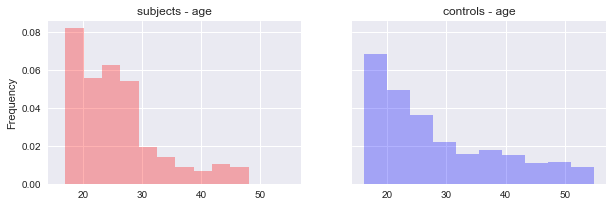

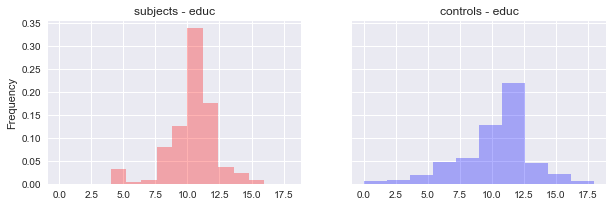

In [8]:
plot_histograms(subjects,controls)

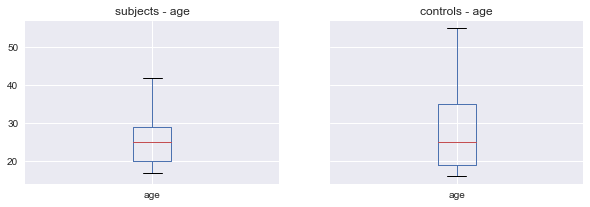

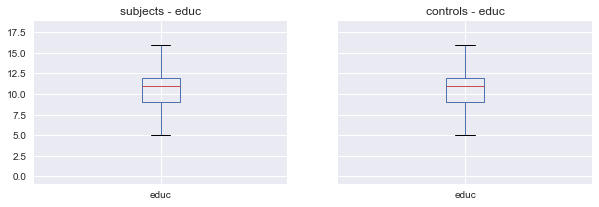

In [9]:
plot_boxs(subjects,controls)

As can be seen on the histograms, the two features age and years of education have similar shapes. 

Age repartition: From histograms, both groups are more dense around 20 years old. However, controls samples spread to higher ages and are more dense after 30 years old compared to subjects.
The boxplots indicate that the two medians are really close but the 75% quantile for controls is higher than for subjects.

Years of education: Subjects have a peak density near 10.5 years whereas controls are centered around 11.5 years. Both have a gaussian-like distribution but controls spread more than subjects.
The box plots indicate that the distributions for subjects and controls are really close (with approximately the same values of quantiles).

##### *** Bulk cathegorical variables ***

For cathegorical features analysis, the proportions are computed and displayed in piecharts.

In [10]:
'''Functions to compute the desired proportions'''

# all the functrions return the proportions in a way that can be used for a piechart (i.e prob and 1-prob)

def race_prop(df):
    N = len(df);
    prop1 = np.sum(df['black'])/N;
    prop2 = np.sum(df['hispan'])/N;
    prop0 = 1-(prop1+prop2);
    return [prop0,prop1,prop2]

def married_prop(df):
    married = np.sum(df['married'])/len(df)
    return [married, 1-married]

def nodegree_prop(df):
    nodegree= np.sum(df['nodegree'])/len(df)
    return [nodegree,1-nodegree]

In [11]:
'''Define a function for porportions display'''

def cathegories_props(subjects, controls):
    
    # race proportion
    race_props = pd.DataFrame(index = ['white','black','hispan'])
    
    race_props['Subjects - race prop'] = race_prop(subjects)
    race_props['Controls - race prop'] = race_prop(controls)
    
    # married proportion
    married_props = pd.DataFrame(index = ['married','single'])
    
    married_props['Subjects - married prop'] = married_prop(subjects)
    married_props['Controls - married prop'] = married_prop(controls)
    
    # no degree proportions
    nodeg_props = pd.DataFrame(index = ['nodegree','degree'])

    nodeg_props['Subjects - nodegree prop'] = nodegree_prop(subjects)
    nodeg_props['Controls - nodegree prop'] = nodegree_prop(controls)
    
    plt.figure(1)
    race_props.plot.pie(autopct='%.2f',figsize=(8.5,4),subplots=True)
    plt.figure(2)
    married_props.plot.pie(autopct='%.2f',figsize=(8.5,4),subplots=True)
    plt.figure(3)
    nodeg_props.plot.pie(autopct='%.2f',figsize=(8.5,4),subplots=True)

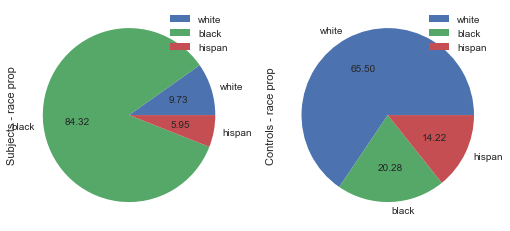

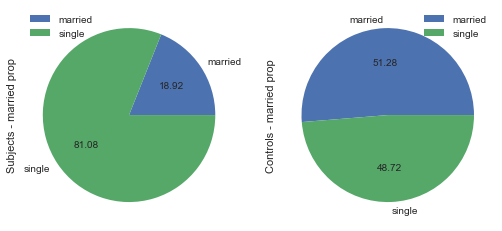

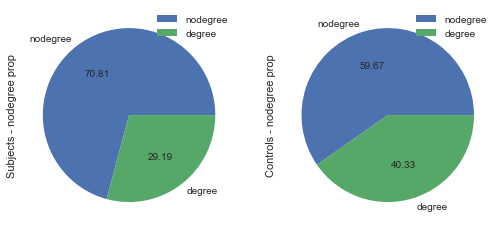

In [12]:
cathegories_props(subjects, controls)

The piecharts allow to see that the proportions of married and of each different ethny are really different amongst samples and subject. 84% of subjects are black whereas only 20.28 % of controls are black, instead there are 65.50% of whites. This is really important because in the dates of the study, there was still a lot of discrimination in the active society. 
Also, the subjects count 81.08% of people single whcich against 48.72 % for controls.

***Statistical Analysis: Earnings in 74, 75 and 78***

In [13]:
def re_stats(subjects,controls):
    distr_re = pd.DataFrame(index = ['count','mean','std','min','25%','50%','75%','max'])
    distr_re[['subjects-re78','subjects-re75','subjects-re74']]= subjects[['re78','re74','re75']].describe()
    distr_re[['controls-re78','controls-re75','controls-re74']]= controls[['re78','re74','re75']].describe()

    averages = np.transpose(distr_re.copy())['mean']
    stds = np.transpose(distr_re.copy())['std']

    meanbars = pd.DataFrame(index=['re78','re75','re74'])
    errorbars = meanbars.copy()

    meanbars['controls'] = list(np.transpose(averages)[['controls-re78','controls-re75','controls-re74']])
    meanbars['subjects'] = list(np.transpose(averages)[['subjects-re78','subjects-re75','subjects-re74']])

    errorbars['controls'] = list(np.transpose(stds)[['controls-re78','controls-re75','controls-re74']])
    errorbars['subjects'] = list(np.transpose(stds)[['subjects-re78','subjects-re75','subjects-re74']])

    plt.figure(1)
    meanbars.plot(kind='barh', xlim= [0, 15000])
    plt.title('average earnings')

    print(distr_re)

       subjects-re78  subjects-re75  subjects-re74  controls-re78  \
count     185.000000     185.000000     185.000000     429.000000   
mean     6349.143530    2095.573689    1532.055314    6984.169742   
std      7867.402218    4886.620353    3219.250870    7294.161791   
min         0.000000       0.000000       0.000000       0.000000   
25%       485.229800       0.000000       0.000000     220.181300   
50%      4232.309000       0.000000       0.000000    4975.505000   
75%      9642.999000    1291.468000    1817.284000   11688.820000   
max     60307.930000   35040.070000   25142.240000   25564.670000   

       controls-re75  controls-re74  
count     429.000000     429.000000  
mean     5619.236506    2466.484443  
std      6788.750796    3291.996183  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%      2547.047000    1086.726000  
75%      9277.128000    3881.419000  
max     25862.320000   18347.230000  


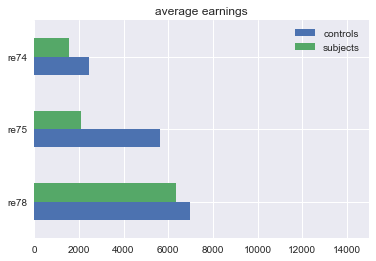

In [14]:
re_stats(subjects,controls)

The quantile distributions allow to see that subjects have a median (50%) at zero in re75 and re74 which indicats that most of the subjects were ennemployed at the time when the study started. Oppositely, the controls have 50% quantiles at more than 1000 dollars. Thus it is obvious that subjects needed more the treatment than controls at the time of the study. 

The bar plot allows to control the average for each group and one can clearly see that controls had in average higher earnings than subjects before the training program (re74, re75). The gap between the two groups seems reduced, however for re78 which is a good sign for the effect of training program.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

*** Propensity scores ***

To compute propensity scores we only have to define features and labels. Labels are given by the treatment column since we want the probability of receiving treatment. All other informations are chosen as features, except the real output (re78) which happens after treatment and thus has nothing to do here.

The distribution of scores (histograms) is computed for each class to support the discussion.

In [15]:
from sklearn import linear_model

''' Compute propensity scores'''

# define features and labels
feature_cols = observed_earnings.drop(['treat','re78'],axis=1).columns
X = observed_earnings[feature_cols]
y = observed_earnings.treat

logistic = linear_model.LogisticRegression()
logistic.fit(X, y) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

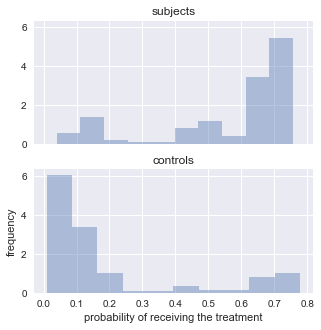

In [16]:
'''Display the results'''

pred = logistic.predict_proba(X)
# the propensity score is the probability of being treated (i.e transpose(scores)[1])
propensity_scores_subjects = np.transpose(pred[y==1])[1] # y == 1 sibjects, y == 0 controls
propensity_scores_controls = np.transpose(pred[y==0])[1]

fig, axes = plt.subplots(2, 1, figsize=(5,5), sharex=True,sharey=True);
axes[0].hist(propensity_scores_subjects,normed=1,alpha=0.4)
axes[0].set_title('subjects')
axes[1].hist(propensity_scores_controls,normed=1,alpha=0.4)
axes[1].set_title('controls')
plt.xlabel('probability of receiving the treatment')
plt.ylabel('frequency')
plt.show()

As expected, the distributions are really different and the subjects have a higher probability of receiving treatment compared to controls. This will typically bias the final result of this observational study.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

*** Matching the groups using networks***

By exploring the documentation of this library we found that matching functions allow to solve a maximum matching problem in bipartite graphs. Bipartite graphs are appropriate for our problem, since we have two groups. The maximum matching allows to reduce weighted connexions to the ones that maximize the sum of weights all keeping only paired connexions from a group to the other.

Here to answer the question, we consider the subjects as the limitting group of nodes and controls as the other group of nodes. Maximization of sum of weights should be equivalent to minimizing the sum of absolute differences of propensity scores. This is simply done by defining weights as MAX - abs(diff) where the MAX is the maximum absolute difference computed all over the data so that wieghts are always positive. The derivative of sum of weights then reduces to our matching optimization problem. 

Procedure:

1) Compute an adjacency matrix which contains absolute differences of scores for each node

2) Building the graph by defining nodes as subjects and controls and weights of connexions as the MAX-abs(diff) thanks to adjacency matrix

3) Calling the matching function to build the map

4) Extracting the filtered controls thank to the previous mapping

5) Comparing features again then to assess If the matching worked properly.

In [17]:
import networkx as nx

def match_two_groups(val_subjects, val_controls):
    
    # build the adjacency matrix which defines the weight of connexion between two nodes (subjects/controls)
    N1 = len(val_subjects)
    N2 = len(val_controls)
    A= np.zeros([N1,N2])

    for i in range(0,N1):
        A[i] = np.abs(val_controls-val_subjects[i])
    
    #build the bipartite graph for matching
    B = nx.Graph()
    B.add_nodes_from(np.arange(0,N1), bipartite=0) # Nodes for subjects are indexed from 0 to Nsubjects
    B.add_nodes_from(np.arange(N1,N1+N2), bipartite=1) # Nodes for controls are indexed from Nsubjects+1 to Ncontrols

    maxx = float(np.max(A)) #the max is used to adapt the optimization problem

    for i in range(0,N1):
        for j in range(0,N2):
            B.add_edge(i,j+N1,weight=maxx-A[i][j]) #add the weighted connexions
        
    #perform the matching with networks: this step takes time to run !    
    mapp = nx.max_weight_matching(B)
    
    # reconstruct the data set
    subjects_ids = np.arange(0,N1)
    controls_ids = []

    for i in range(0,N1):
        num = mapp[i] #find the index matched (control) to the current index (subject)
        controls_ids.append(num-N1) #adapt the index for the control df index
        
        
    return controls_ids

In [18]:
controls_ids = match_two_groups(propensity_scores_subjects, propensity_scores_controls)

From this mapping, we have to extract the new control group and check If they are uniques (no control id appears two times)

In [208]:
''' Reconstruct the new controls dataframe'''
def retained_df(df, retained_ids): 
    new_df = df.copy()
    new_df['enum'] = list(np.arange(0,len(df.index)))
    new_df = new_df.loc[new_df['enum'].isin(retained_ids)]
    new_df = new_df.drop('enum',axis=1)
    
    return new_df

new_controls = retained_df(controls, controls_ids)    
new_controls.index.is_unique

True

To check how the matching worked, the distributions of propensity scores are plotted and compared to the initial ones.

In [187]:
'''Retreive the unretained controls to evaluate the matching'''
def no_retained_ids(df, retained_ids):
    unretained = df.copy()
    unretained['enum'] = list(np.arange(0,len(df.index)))
    unretained = unretained.loc[unretained['enum'].isin(retained_ids) == False]
    unretained_ids = list(unretained['enum'])
    
    return unretained_ids, unretained.drop('enum',axis=1)

In [188]:
unretained_ids, unretained = no_retained_ids(controls,controls_ids)

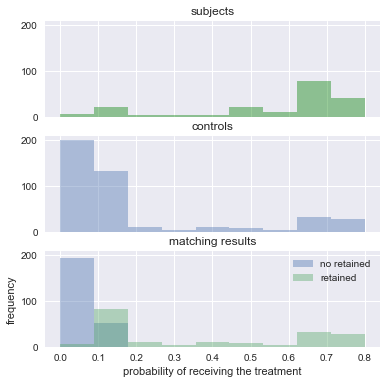

In [189]:
'''Display to check the matching'''

fig, axes = plt.subplots(3, 1, figsize=(6,6), sharex=True,sharey=True);
bins = np.linspace(0,0.8,10)
axes[0].hist(propensity_scores_subjects,normed=0,bins=bins, facecolor='green',alpha=0.4)
axes[0].set_title('subjects')
axes[1].hist(propensity_scores_controls,normed=0,bins=bins,alpha=0.4)
axes[1].set_title('controls')
axes[2].hist(propensity_scores_controls[unretained_ids],normed=0,bins=bins,alpha=0.4)
axes[2].hist(propensity_scores_controls[controls_ids],normed=0,bins=bins,alpha=0.4)
axes[2].set_title('matching results')
axes[2].legend(['no retained','retained'])
plt.xlabel('probability of receiving the treatment')
plt.ylabel('frequency')
plt.show()

As the subjects had in general high orobabilities of receiving the tratment, the matching worked by extractint all the elements of controls that had a high propensity score (green in matching result). As some subjecsts had also a low propensity score, these were matched with some controls in the smaller part of the distribution.

*** Now we will analyze features distributions*** and see If they are ballanced.

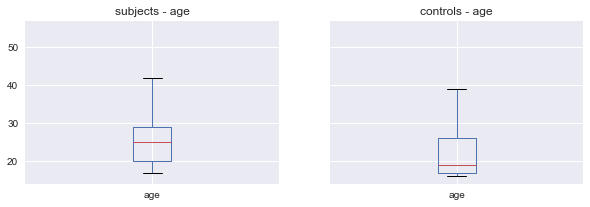

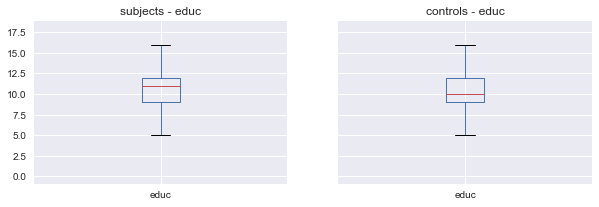

In [209]:
plot_boxs(subjects,new_controls)

The ages are and years of education are less ballanced now in terms of medians. But note that the controls have less extreme ages (recall that initially there were outliers between 40 and 50 years). In general, younger people have less years of education (since they are already working at their age) which may explain why the decrease in age median correlated with a decreased in years of education in the control group.

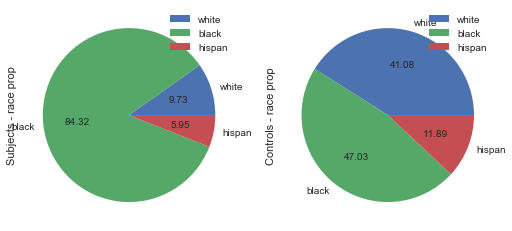

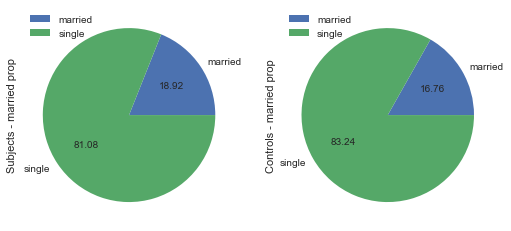

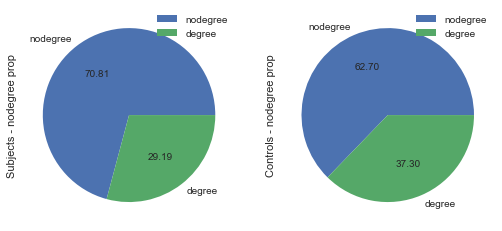

In [210]:
cathegories_props(subjects, new_controls)

Proportions are much more ballanced now for nodegree and married features which is good for the study. Before, the controls were build with 20% of black people and 65.50% of white people and now the black people represent 47% against 41% of white people. In control group also they were 41% of single whereas now they represent 83% of the group.

       subjects-re78  subjects-re75  subjects-re74  controls-re78  \
count     185.000000     185.000000     185.000000     185.000000   
mean     6349.143530    2095.573689    1532.055314    5312.474907   
std      7867.402218    4886.620353    3219.250870    5842.884861   
min         0.000000       0.000000       0.000000       0.000000   
25%       485.229800       0.000000       0.000000       0.000000   
50%      4232.309000       0.000000       0.000000    3392.860000   
75%      9642.999000    1291.468000    1817.284000    7933.914000   
max     60307.930000   35040.070000   25142.240000   20243.380000   

       controls-re75  controls-re74  
count     185.000000     185.000000  
mean     2095.885961    1615.306428  
std      4029.201886    2674.747685  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%       289.971500     451.161300  
75%      2068.986000    1890.581000  
max     21918.320000   13776.530000  


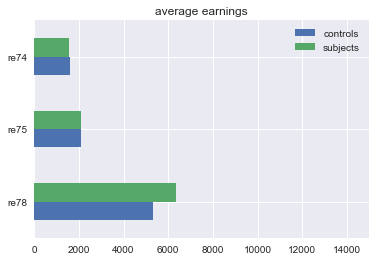

In [192]:
re_stats(subjects,new_controls)

The median of earnings in 1974 and 1975 are still non-zero but now they are bellow 500 compared to more than 1000 in the previous repartition. Also the average earnings before the training program are practically identical between the two groups. This is really better for the observational study.
Note that now it appears more clearly that the average earnings in 1978 is higher for subjects than for controls.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

In [198]:
def build_races(df):
    new_df = df.copy()
    race = np.array(1*df['black']+2*df['hispan']) 
    new_df['race'] = race
    new_df['memm_idx'] = np.arange(0,len(df.index))
    
    black = new_df[new_df['race']==1]
    hispan = new_df[new_df['race']==2]
    white = new_df[new_df['race']==0]
    
    return black, hispan, white, race

In [199]:
black_subjects, hispan_subjects, white_subjects, race_subjs = build_races(subjects)

len(black_subjects.index), len(hispan_subjects.index), len(white_subjects.index)

(156, 11, 18)

In [200]:
black_controls, hispan_controls, white_controls, race_ctrls = build_races(controls)

len(black_controls.index), len(hispan_controls.index), len(white_controls.index)

(87, 61, 281)

In [226]:
hispan_match = match_two_groups(propensity_scores_subjects[np.where(race_subjs==2)],
                                propensity_scores_controls[np.where(race_ctrls==2)])

white_match = match_two_groups(propensity_scores_subjects[np.where(race_subjs==0)],
                               propensity_scores_controls[np.where(race_ctrls==0)])

In [134]:
black_inverse_match = match_two_groups(propensity_scores_controls[np.where(race_ctrls==1)],
                                       propensity_scores_subjects[np.where(race_subjs==1)])

In [227]:
hisp_no_ids, hisp_no_retained = no_retained_ids(hispan_controls, hispan_match)
white_no_ids, white_no_retained  = no_retained_ids(white_controls, white_match)

no_retained_ctrls = pd.concat([hisp_no_retained,white_no_retained])
no_retained_ctrls_ids = list(no_retained_ctrls['memm_idx'])

In [228]:
black_subjs_no_ids, black_subjs_no_retained = no_retained_ids(black_subjects, black_inverse_match)

no_retained_subjs_ids = list(black_subjs_no_retained['memm_idx'])

In [229]:
remain_match = match_two_groups(propensity_scores_subjects[no_retained_subjs_ids],
                                propensity_scores_controls[no_retained_ctrls_ids])

In [230]:
new_controls_hisp = retained_df(hispan_controls, hispan_match)
new_controls_white = retained_df(white_controls, white_match)
new_controls_remain = retained_df(no_retained_ctrls, remain_match)
new_controls_black = black_controls

retained_df_controls = pd.concat([new_controls_hisp,new_controls_white,new_controls_black,new_controls_remain])

In [231]:
len(retained_df_controls.index), len(subjects), retained_df_controls.index.is_unique

(185, 185, True)

In [240]:
fcontrols = retained_df_controls.drop('memm_idx',axis=1).drop('race',axis=1)

       subjects-re78  subjects-re75  subjects-re74  controls-re78  \
count     185.000000     185.000000     185.000000     185.000000   
mean     6349.143530    2095.573689    1532.055314    5312.474907   
std      7867.402218    4886.620353    3219.250870    5842.884861   
min         0.000000       0.000000       0.000000       0.000000   
25%       485.229800       0.000000       0.000000       0.000000   
50%      4232.309000       0.000000       0.000000    3392.860000   
75%      9642.999000    1291.468000    1817.284000    7933.914000   
max     60307.930000   35040.070000   25142.240000   20243.380000   

       controls-re75  controls-re74  
count     185.000000     185.000000  
mean     2095.885961    1615.306428  
std      4029.201886    2674.747685  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%       289.971500     451.161300  
75%      2068.986000    1890.581000  
max     21918.320000   13776.530000  


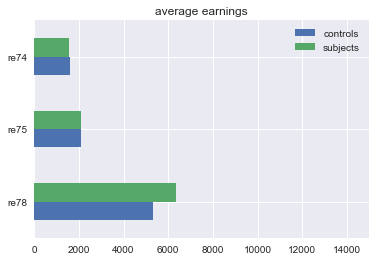

In [242]:
re_stats(subjects,new_controls)

       subjects-re78  subjects-re75  subjects-re74  controls-re78  \
count     185.000000     185.000000     185.000000     185.000000   
mean     6349.143530    2095.573689    1532.055314    5260.482868   
std      7867.402218    4886.620353    3219.250870    5776.120954   
min         0.000000       0.000000       0.000000       0.000000   
25%       485.229800       0.000000       0.000000      33.987710   
50%      4232.309000       0.000000       0.000000    3057.416000   
75%      9642.999000    1291.468000    1817.284000    7933.914000   
max     60307.930000   35040.070000   25142.240000   20243.380000   

       controls-re75  controls-re74  
count     185.000000     185.000000  
mean     2095.970689    1705.703206  
std      4025.179527    2713.902132  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%       311.523400     558.580600  
75%      2068.986000    2255.806000  
max     21918.320000   13776.530000  


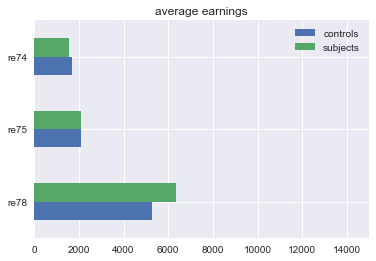

In [243]:
re_stats(subjects,fcontrols)

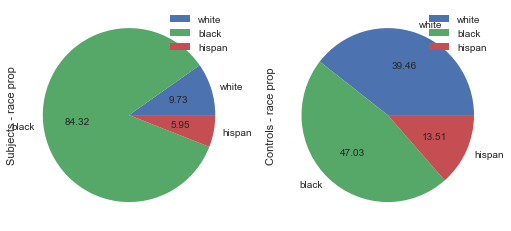

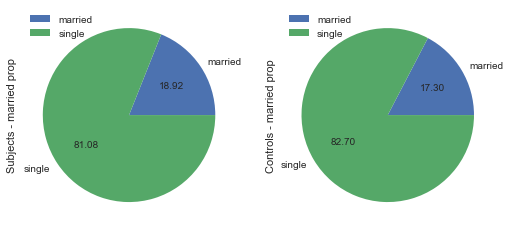

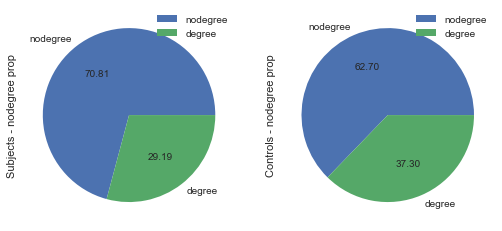

In [244]:
cathegories_props(subjects, fcontrols)

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [245]:
new_dat = pd.concat([subjects, fcontrols])
new_dat.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [246]:
ns = len(observed_earnings.index)

ns = len(new_dat.index)
X, y = new_dat.re78.values, new_dat.treat.values
F, p_val = f_classif(X.reshape([ns,1]),y.reshape(ns))

print('The Fisher ANOVA tests returns a p-value of {} for re78'.format(float(p_val)))

The Fisher ANOVA tests returns a p-value of 0.13009131295831766 for re78


In [251]:
from sklearn.feature_selection import chi2

X, y = new_dat.re78.values, new_dat.treat.values
scores, pvalues = chi2(X.reshape([ns,1]),y.reshape(ns))
scores, pvalues

(array([ 18885.93736766]), array([ 0.]))

In reverse of the conclusion drawn in part 1, we can see an improvement in the earning of the subjects that have followed the job training program. We can conclude that this program is effective.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1) Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency-inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokenize = lambda doc: doc.lower().split(" ")
sklearn_tfidf = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)


2) Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.